In [73]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.linalg as la
from sklearn.svm import SVC
# from JDIP import JDIP
# from MSJDIP import MSJDIP
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale,LabelEncoder
from os import path as osp
import autograd.numpy as anp
import autograd.numpy.linalg as alina
import pymanopt as pm
import pymanopt.manifolds as manifolds
import pymanopt.optimizers as optimizers
from sklearn.metrics import pairwise_distances
import autograd.numpy as anp
import autograd.numpy.linalg as alina
import numpy as np
import numpy.linalg as nlina
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

In [2]:
def RMI_np(FX,y,l,sigma=0.8,alpha=0.5,lamda=1e-2):
    '''
    FX: numpy array of feature. eg: vstack(Xs)
    y: numpy array of labels
    l: numpy array of domain labels
    
    return -->float RCS Divergence of FX,y,l
    '''
    # print(FX)
    m=FX.shape[0]
    # print('m:',m)
    
    Deltay=(y[:,None]==y).astype(float)
    Deltal=(l[:,None]==l).astype(float)
    FX_norm=anp.sum(FX**2,axis=-1)#这里由于做了归一化 所以始终都等于1 后面要考虑下要不要改
    # print(FX_norm,FX_norm.shape)
    # print('1',FX_norm[:,None],FX_norm[None,:])
    # print(FX_norm[:,None].shape,FX_norm[None,:].shape)
    A=-(FX_norm[:,None] + FX_norm[None,:])
    # print("A",A.shape)
    B=2 * anp.dot(FX, FX.T)
    # print("B",B.shape)
    K=anp.exp(-(FX_norm[:,None] + FX_norm[None,:] - 2 * anp.dot(FX, FX.T)) / sigma) * Deltay
    # print('K is',K.shape)
    P = K * Deltal
    # print("P is",P.shape)
    H = ((1.0 - alpha) / m**2) * anp.dot(K,K) * anp.dot(Deltal,Deltal) + 1.0 * alpha / m * anp.dot(P,P)
    h = anp.mean(P,axis=0)
    h=h.reshape((h.shape[0],))#对齐一下向量

    # theta = anp.matrix(H + lamda * anp.eye(m)).I.dot(h)
    theta=alina.solve(H + lamda * anp.eye(m),h)
    
    D = 2 * anp.dot(h.T,theta)-anp.dot(theta.T,anp.dot(H,theta)) - 1
    # print(D,type(D))

    # print(H.shape,h.shape,theta.shape)
    return D

In [3]:
def readDataMS(root,scs,tg,Cs_end,Cu_start,fn='fea',postfix=''): 
    '''
    root: 数据集路径,eg 'OSDA-2/Office-31_Alex/Data_office31'
    scs: List of source domain name, eg ['dslr','webcam']
    tg: name of target domain name, eg 'amazon'
    Cs_end: Known end
    Cu_start: Unknown start
    fn: 在mat文件中feature列名 
    postfix: 每个数据集文件的后缀名

    return: 
        Xs: List of numpy array
        Xt: Numpy array
        l: numpy array of label of the sample

    '''
    Xs,ys,l=[],[],[]
    li=0
    for sc in scs:
        data = sio.loadmat(osp.join(root ,sc + postfix+'.mat'))# source domain 
        Xsi,ysi = data[fn].astype(np.float64),data['labels'].ravel()
        ysi = LabelEncoder().fit(ysi).transform(ysi).astype(np.float64)
        Xsi = Xsi / la.norm(Xsi,axis=1,keepdims=True)
        Xsn=Xsi[ysi[:]<Cs_end,:]
        ysn=ysi[ysi[:]<Cs_end]#筛选出已知类
        Xs.append(Xsn)
        ys.append(ysn)
        l=np.hstack((np.array(l),np.full((Xsn.shape[0],),li)))
        li+=1

    data = sio.loadmat(osp.join(root , tg + postfix+'.mat'))# target domain 
    Xt,yt = data[fn].astype(np.float64),data['labels'].ravel()
    yt = LabelEncoder().fit(yt).transform(yt).astype(np.float64)
    C=len(np.unique(yt))
    # index_unknwon=yt[yt[:]>Cs_end and yt[:]<Cu_start]
    print('Cu_start:',Cu_start)
    Xt=np.vstack((Xt[yt[:]<Cs_end,:],Xt[yt[:]>=Cu_start,:]))#筛选已知类和未知类
    yt=np.hstack((yt[yt[:]<Cs_end],yt[yt[:]>=Cu_start]))

    l=np.hstack((np.array(l),np.full((Xt.shape[0],),li)))
    
    Xt = Xt / la.norm(Xt,axis=1,keepdims=True)

    Cs = Cs_end
    Cu = C - Cu_start

    return Xs,ys,Xt,yt,l,Cs,Cu

def compute_acc(Y, Y_pseudo, Cs):
    acc_known = 0
    acc_unknown = 0
    known_i = 0
    unknown_i = 0
    mtk = Y[Y < Cs].shape
    mtu = Y[Y >= Cs].shape
    mt = Y.shape
    # 计算已知类的分类准确率
    for c in range(Cs):  
        known_i += np.sum(Y_pseudo[Y == c] == Y[Y == c]) 
    acc_known = known_i/mtk
    # 计算未知类的分类准确率
    unknown_i = np.sum(Y_pseudo[Y >= Cs ] == Cs)
    acc_unknown = unknown_i/mtu
    # 计算总体分类准确率
    acc = (unknown_i+known_i)/mt
    print('use this')
    return acc,acc_unknown,acc_known

In [4]:
def pseudo_fuc_ms(Xs, ys, Xt, Yt,Cs,Cu,conf=0):
    # 1.加载数据
    Xs=np.vstack(Xs)
    ys=np.hstack(ys)

    Xs = scale(Xs, with_std=False)
    Xt = scale(Xt, with_std=False)


    # 2.设置分类模型,标注已知类伪标签
    Xt_label, Xt_labelConf = cla_Svc(Xs, Xt, ys)

    # conf = -0.25  # 根据SVM定义,置信度大于0才属于已知类
    Xtk = Xt[Xt_labelConf >= conf]
    Ytk = Yt[Xt_labelConf >= conf]
    Ytk_pseudo = Xt_label[Xt_labelConf >= conf]
    Xtu = Xt[Xt_labelConf < conf]
    Ytu = Yt[Xt_labelConf < conf]
    Ytu_pseudo = Xt_label[Xt_labelConf < conf]
    Ytu_pseudo[:] = Cs
    

    # 5.目标域数据整合
    Xt_new = np.vstack((Xtk, Xtu))
    Yt_new = np.hstack((Ytk, Ytu))
    Yt_pseudo = np.hstack((Ytk_pseudo, Ytu_pseudo))
    

    # print('Yt_new')
    # print(Yt_new.astype('int'))
    # print("Yt_pseudo")
    # print(Yt_pseudo)
    
    acc,acc_unknown,acc_known=compute_acc(Yt_new,Yt_pseudo,Cs)
    # acc_known=compute_acc_known(Yt_new[Yt_new < Cs],Yt_pseudo[Yt_new < Cs], Cs)
    # one_unknown=compute_one_unknown(Yt_new[Yt_new >= Cs], Yt_pseudo[Yt_new >= Cs], Cs)
    print("pseudo Xtk:", acc_known)
    print("pseudo Xtu:", acc_unknown)
    print('all acc',acc)
        # one_acc = (acc_known * Cs + one_unknown) / (Cs + 1)
    # 计算已知类准确率,后续应删
    # Ytk_new = Yt_new[Yt_new < Cs]
    # print("Ytk_new",Ytk_new)
    # Ytk_new_pseudo = Yt_pseudo[Yt_new < Cs]
    # print("Ytk_new_pe",Ytk_new_pseudo)
    # acc_known = compute_acc_known(Ytk_new, Ytk_new_pseudo, Cs)
    # print("predict Xtk :", acc_known)
    # # 计算未知类准确率,后续应删
    # Ytu_new = Yt_new[Yt_new >= Cs]
    # Ytu_new_pseudo = Yt_pseudo[Yt_new >= Cs]
    # one_unknown = compute_one_unknown(Ytu_new, Ytu_new_pseudo, Cs)
    # print("predict Xtu one :", one_unknown)

    # # 计算总体准确率
    # one_acc = (acc_known * Cs + one_unknown) / (Cs + 1)
    # print("predict Xt one:", one_acc)

    return Xt_new,Yt_new,Yt_pseudo

In [63]:
def cla_Svc(Xs, Xt, Ys):
    # 2.SVM分类模型
    model_cla = LinearSVC(dual=False)  # dual决定无法收敛时取消默认1000的迭代次数
    model_cla.fit(Xs, Ys)
    conf_matrix = model_cla.decision_function(Xt)
    conf_label = conf_matrix.argmax(axis=1)  # 每个样本最大置信度的索引,即类
    conf_vec = np.max(conf_matrix, axis=1)  # 每个样本最大置信度

    return conf_label, conf_vec

# def compute_acc(Y, Y_pseudo, Cs):
#     acc_known = 0
#     acc_unknown = 0
#     known_i = 0
#     unknown_i = 0
#     mtk = Y[Y < Cs].shape
#     mtu = Y[Y >= Cs].shape
#     mt = Y.shape
#     # 计算已知类的分类准确率
#     for c in range(Cs):  
#         known_i += np.sum(Y_pseudo[Y == c] == Y[Y == c]) 
#     acc_known = known_i/mtk
#     # 计算未知类的分类准确率
#     unknown_i = np.sum(Y_pseudo[Y >= Cs ] == Cs)
#     acc_unknown = unknown_i/mtu
#     # 计算总体分类准确率
#     acc = (unknown_i+known_i)/mt
#     print('use this')
#     return acc,acc_unknown,acc_known
def compute_acc(Y, Y_pseudo, Cs):
    acc_os_all = 0
    acc_os_k = 0
    os = 0
    os_1 = 0 
    # print(Y)
    # print(Y_pseudo)
    # 计算已知类的分类准确率
    for c in range(Cs):
        os_1 = np.sum(Y_pseudo[Y == c] == Y[Y == c]) /Y[Y == c].shape
        acc_os_k += os_1
    acc_os_k = acc_os_k/Cs
    print(acc_os_k)
    # 计算未知类的分类准确率
    for c in range(Cs):
        os = np.sum(Y_pseudo[Y == c] == Y[Y == c]) /Y[Y == c].shape
        acc_os_all += os 
    os_unk = np.sum(Y_pseudo[Y >= Cs ] == Cs)/Y[Y >= Cs ].shape
    acc_os_all += os_unk
    acc_os_all = acc_os_all/(Cs+1)
    HOS=2*(acc_os_k*os_unk)/(acc_os_k+os_unk)
    return acc_os_all,acc_os_k,os_unk,HOS

In [6]:
import numpy as np
np.set_printoptions(threshold=1e6)

In [86]:
scs=['amazon','webcam']
tg='dslr'
root=osp.join('Office-31_Alex','Data_office31')

eta=0.001
gamma_tk=0.2
gamma_tu=0.7
gamma_s=0.35

print("DataSet:{}".format(root),"\nTarget Domain:{}".format(tg))

Xs,ys,Xt,yt,l,Cs,Cu=readDataMS(root,scs,tg,20,21,fn='fts',postfix='_Al7')


DataSet:Office-31_Alex\Data_office31 
Target Domain:dslr
Cu_start: 21


In [40]:
Xs=np.vstack(Xs)
ys=np.hstack(ys)
Xs = scale(Xs, with_std=False)
Xt = scale(Xt, with_std=False)
# 2.设置分类模型,标注已知类伪标签
Xt_label, Xt_labelConf = cla_Svc(Xs, Xt, ys)

In [39]:
Yt=yt

In [65]:
k_conf=0
u_conf=-0.2
Xtk = Xt[Xt_labelConf >= k_conf]
Ytk = Yt[Xt_labelConf >= k_conf]
Ytk_pseudo = Xt_label[Xt_labelConf >= k_conf]
Xtu = Xt[Xt_labelConf < u_conf]
Ytu = Yt[Xt_labelConf < u_conf]
Ytu_pseudo = Xt_label[Xt_labelConf < u_conf]
Ytu_pseudo[:] = Cs

Xt_new = np.vstack((Xtk, Xtu))
Yt_new = np.hstack((Ytk, Ytu))
Yt_pseudo = np.hstack((Ytk_pseudo, Ytu_pseudo))

In [66]:
acc,acc_k,acc_uk,HOS=compute_acc(Yt_new,Yt_pseudo,Cs)
print("pseudo acc:", acc)
print("pseudo acc_k:", acc_k)
print('acc_uk:',acc_uk)
print('HOS:',HOS)

[0.40653438]
pseudo acc: [0.42987279]
pseudo acc_k: [0.40653438]
acc_uk: [0.89664083]
HOS: [0.55942643]


In [87]:
def pseudo_fuc_ms_progressive(Xs, ys, Xt, Yt,Cs,Cu,k_conf=0,u_conf=-0.2):
    # 1.加载数据
    Xs=np.vstack(Xs)
    ys=np.hstack(ys)

    Xs = scale(Xs, with_std=False)
    Xt = scale(Xt, with_std=False)


    # 2.设置分类模型,标注已知类伪标签
    Xt_label, Xt_labelConf = cla_Svc(Xs, Xt, ys)

    # conf = -0.25  # 根据SVM定义,置信度大于0才属于已知类
    Xtk = Xt[Xt_labelConf >= k_conf]
    Ytk = Yt[Xt_labelConf >= k_conf]
    Ytk_pseudo = Xt_label[Xt_labelConf >= k_conf]
    Xtu = Xt[Xt_labelConf < u_conf]
    Ytu = Yt[Xt_labelConf < u_conf]
    Ytu_pseudo = Xt_label[Xt_labelConf < u_conf]
    Ytu_pseudo[:] = Cs
    

    # 5.目标域数据整合
    Xt_new = np.vstack((Xtk, Xtu))
    Yt_new = np.hstack((Ytk, Ytu))
    Yt_pseudo = np.hstack((Ytk_pseudo, Ytu_pseudo))
    
    print('sample Size:',Yt_new.shape)
    
    acc,acc_k,acc_uk,HOS=compute_acc(Yt_new,Yt_pseudo,Cs)
    print("pseudo acc:", acc)
    print("pseudo acc_k:", acc_k)
    print('acc_uk:',acc_uk)
    print('HOS:',HOS)

    return Xt_new,Yt_new,Yt_pseudo,acc,acc_k,acc_uk,HOS
u_confs=[]
accs,acc_ks,acc_uks,HOSs=[],[],[],[]
for i in range(0,10):
    k_conf=0
    u_conf=-i/10
    u_confs.append(u_conf)
    print(k_conf,u_conf)
    _,_,_,acc,acc_k,acc_uk,HOS=pseudo_fuc_ms_progressive(Xs,ys,Xt,yt,Cs,Cu,k_conf=k_conf,u_conf=u_conf)
    accs.append(acc)
    acc_ks.append(acc_k)
    acc_uks.append(acc_uk)
    HOSs.append(HOS)


0 0.0
sample Size: (485,)
[0.88016653]
pseudo acc: [0.8741722]
pseudo acc_k: [0.88016653]
acc_uk: [0.75428571]
HOS: [0.81237863]
0 -0.1
sample Size: (464,)
[0.89715576]
pseudo acc: [0.88941348]
pseudo acc_k: [0.89715576]
acc_uk: [0.7345679]
HOS: [0.80776156]
0 -0.2
sample Size: (429,)
[0.93131602]
pseudo acc: [0.92016683]
pseudo acc_k: [0.93131602]
acc_uk: [0.6971831]
HOS: [0.79741865]
0 -0.3
sample Size: (403,)
[0.947669]
pseudo acc: [0.93351364]
pseudo acc_k: [0.947669]
acc_uk: [0.6504065]
HOS: [0.77139044]
0 -0.4
sample Size: (378,)
[0.97473856]
pseudo acc: [0.95698205]
pseudo acc_k: [0.97473856]
acc_uk: [0.60185185]
HOS: [0.74419862]
0 -0.5
sample Size: (355,)
[0.9825]
pseudo acc: [0.95979748]
pseudo acc_k: [0.9825]
acc_uk: [0.50574713]
HOS: [0.66776081]
0 -0.6
sample Size: (333,)
[0.9825]
pseudo acc: [0.9518315]
pseudo acc_k: [0.9825]
acc_uk: [0.33846154]
HOS: [0.5034794]
0 -0.7
sample Size: (320,)
[0.985]
pseudo acc: [0.94707996]
pseudo acc_k: [0.985]
acc_uk: [0.18867925]
HOS: [0

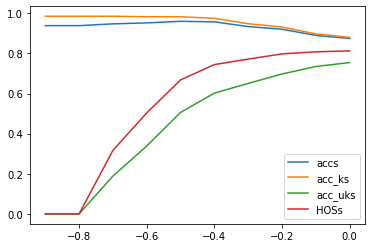

In [88]:
#'Dslr'
plt.plot(u_confs,accs,label='accs')
plt.plot(u_confs,acc_ks,label='acc_ks')
plt.plot(u_confs,acc_uks,label='acc_uks')
plt.plot(u_confs,HOSs,label='HOSs')
plt.legend()

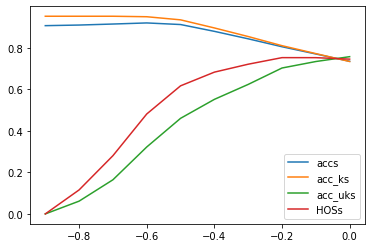

In [85]:
#'Webcam'
plt.plot(u_confs,accs,label='accs')
plt.plot(u_confs,acc_ks,label='acc_ks')
plt.plot(u_confs,acc_uks,label='acc_uks')
plt.plot(u_confs,HOSs,label='HOSs')
plt.legend()

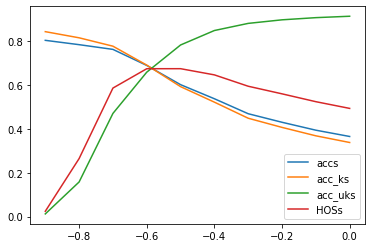

In [80]:
#Amazon
plt.plot(u_confs,accs,label='accs')
plt.plot(u_confs,acc_ks,label='acc_ks')
plt.plot(u_confs,acc_uks,label='acc_uks')
plt.plot(u_confs,HOSs,label='HOSs')
plt.legend()

In [9]:
for i in range(-9,9,1):
    KnownDividePart=yt[Xt_labelConf>i/10]
    # print(KnownDividePart)
    KnownSample=KnownDividePart[KnownDividePart<Cu]
    KnownRate=(KnownSample.shape[0])/max(1,KnownDividePart.shape[0])
    
    # KnownRate=yt[(Xt_labelConf>i/10) & (yt<Cu)].shape[0]/yt[(Xt_labelConf>i/10)].shape[0]
    # UnknownRate=yt[(Xt_labelConf<i/10) & (yt>Cu)].shape[0]/yt[(Xt_labelConf<i/10)].shape[0]
    print(i/10,KnownRate)

-0.9 0.44880174291938996
-0.8 0.4490463215258856
-0.7 0.45104510451045104
-0.6 0.46736596736596736
-0.5 0.5006622516556292
-0.4 0.5561797752808989
-0.3 0.6261127596439169
-0.2 0.7167919799498746
-0.1 0.7889908256880734
0.0 0.839851024208566
0.1 0.8981042654028436
0.2 0.9395770392749244
0.3 0.9767441860465116
0.4 0.9951690821256038
0.5 1.0
0.6 1.0
0.7 1.0
0.8 1.0


In [10]:
for i in range(-9,9,1):
    KnownDividePart=yt[Xt_labelConf<i/10]
    KnownSample=KnownDividePart[KnownDividePart>=Cu]
    KnownRate=(KnownSample.shape[0])/max(1,KnownDividePart.shape[0])
    
    # KnownRate=yt[(Xt_labelConf>i/10) & (yt<Cu)].shape[0]/yt[(Xt_labelConf>i/10)].shape[0]
    # UnknownRate=yt[(Xt_labelConf<i/10) & (yt>Cu)].shape[0]/yt[(Xt_labelConf<i/10)].shape[0]
    print(i/10,KnownRate)

-0.9 0.0
-0.8 1.0
-0.7 0.7777777777777778
-0.6 0.8166666666666667
-0.5 0.7914110429447853
-0.4 0.7779661016949152
-0.3 0.7684848484848484
-0.2 0.7572254335260116
-0.1 0.739424703891709
0.0 0.7128560431100847
0.1 0.6852899575671852
0.2 0.6591362126245848
0.3 0.6375158428390367
0.4 0.6206261510128913
0.5 0.6070785842831433
0.6 0.5935483870967742
0.7 0.5839584535487594
0.8 0.5736961451247166


In [11]:
yt[(Xt_labelConf<-0.7)]

array([ 3.,  7.,  8.,  8., 20., 21., 21., 22., 23., 23., 23., 23., 23.,
       23., 23., 27., 27., 29.])

In [12]:
yt[(Xt_labelConf<-0.7) & (yt>Cu)].shape[0]/yt[(Xt_labelConf<-0.7)].shape[0]

0.7777777777777778

In [13]:
scs=['webcam','amazon']
tg='dslr'
root=osp.join('Office-31_Alex','Data_office31')

eta=0.001
gamma_tk=0.2
gamma_tu=0.7
gamma_s=0.35

print("DataSet:{}".format(root),"\nTarget Domain:{}".format(tg))

Xs,ys,Xt,yt,l,Cs,Cu=readDataMS(root,scs,tg,10,20,fn='fts',postfix='_Al7')


Xt_new,Yt_new,Yt_pseudo=pseudo_fuc_ms(Xs,ys,Xt,yt,Cs,Cu)

# print(yt)

Xs_all=np.vstack(Xs)
Xs_all = scale(Xs_all, with_std=False)
ys_all=np.hstack(ys)

np.random.seed(0)  # 使得PCA算法稳定
pca = PCA(svd_solver="full").fit(np.vstack((Xs_all,Xt)))
W0 = pca.components_.T  # 初始化降维矩阵为Dxd维,D＞d
Ws, Wt = W0, W0
# print(Ws.shape)
accs,acc_knowns,acc_unknowns=[],[],[]

DataSet:Office-31_Alex\Data_office31 
Target Domain:dslr
Cu_start: 20
use this
pseudo Xtk: [0.92207792]
pseudo Xtu: [0.78191489]
all acc [0.84502924]


In [14]:
Ys,Yt=ys_all,Yt_pseudo
Xs=Xs_all
Xtk = Xt[Yt < Cs, :]
Ytk = Yt[Yt < Cs]
lk=l[np.hstack((Ys,Yt))<Cs]
# 融合源域和目标域
Yk_all=np.hstack((Ys,Ytk))
Xk_all=np.vstack((Xs,Xtk))

In [15]:
known_dist = pairwise_distances(Xk_all,Xk_all, 'euclidean')**2
known_sigma = np.median(known_dist[known_dist != 0])
known_rcs=RMI_np(Xk_all,Yk_all,lk,sigma=known_sigma)


In [16]:
print("k_sigma:{}\tk_rcs:{}".format(known_sigma,known_rcs))

k_sigma:0.9399978000419108	k_rcs:0.1640910146313741


In [17]:
unique,count=np.unique(lk,return_counts=True)
unique,count=int(unique),int(count)

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
print(unique,count)

[0. 1. 2.] [154 824 252]


In [ ]:
def RCS(x,y,lk):
    known_dist = pairwise_distances(x,x, 'euclidean')**2
    known_sigma = np.median(known_dist[known_dist != 0])
    known_rcs=RMI_np(x,y,lk,alpha=0,sigma=known_sigma)
    return known_sigma,known_rcs

In [ ]:
remove=0
sigma,rcs=RCS(Xk_all[lk!=remove],Yk_all[lk!=remove],lk[lk!=remove])
print(sigma,rcs)

0.9438689719053157 0.4595536247491945


In [ ]:
a=[0 for i in range(10)]

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)
X_embedded.shape

(4, 2)

In [ ]:
import torch

In [ ]:
cls_path='save_fea/pre_tar_cls.pt'
cls=torch.load(cls_path,map_location=torch.device('cpu'))

In [ ]:
cls

tensor([[1.0000e+00, 2.0000e-04, 2.4414e-03,  ..., 6.2725e-04, 4.4940e-04,
         3.7491e-05],
        [1.0000e+00, 1.4230e-05, 2.3501e-05,  ..., 7.4545e-06, 1.9134e-05,
         1.6014e-06],
        [1.0000e+00, 6.8579e-06, 2.0717e-05,  ..., 6.5859e-06, 5.6389e-06,
         5.4922e-07],
        ...,
        [8.5730e-03, 1.5260e-03, 2.7299e-03,  ..., 2.2265e-03, 9.9995e-01,
         1.2204e-04],
        [2.5120e-01, 4.9872e-02, 7.8490e-01,  ..., 2.5207e-01, 3.0864e-01,
         1.2800e-02],
        [1.7169e-01, 6.7263e-02, 2.8447e-01,  ..., 1.7237e-02, 6.5625e-01,
         1.2359e-02]])

In [ ]:
values,indices=torch.max(cls,dim=1)

In [ ]:
indices[235:]

tensor([5, 5, 8, 8, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 9, 9,
        9, 9, 3, 6, 6, 9, 6, 9, 6, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 9, 6, 3, 8, 8, 6, 3, 6, 3,
        3, 4, 6, 6, 6, 8, 3, 6, 7, 6, 7, 8, 7, 7, 8, 6, 7, 7, 6, 3, 7, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 9, 6, 9, 9, 6, 6, 9, 6, 9, 9, 6, 6,
        9, 8, 9, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 4,
        7, 2, 7, 7, 4, 7, 7, 2, 2, 7, 7, 7, 7, 8, 2, 7, 4, 2, 2, 2, 2, 4, 2, 4,
        4, 6, 6, 6, 6, 6, 6, 6, 6, 2, 8, 8, 6, 6, 6, 6, 4, 6, 2, 8, 8, 8, 8, 8,
        8, 6, 6, 8, 6, 6, 6, 5, 6, 5, 6, 5, 9, 6, 6, 6, 6, 6, 9, 9, 9, 9, 6, 6,
        9, 6, 6, 6, 6, 6, 6, 4, 5, 5, 5, 6, 5, 3, 5, 9, 6, 7, 7, 6, 6, 6, 3, 7,
        7, 8, 6, 7, 6, 5, 9, 8, 8, 8, 9, 9, 9, 9, 8, 0, 8, 9, 0, 2, 0, 9, 9, 6,
        9, 2, 9])

In [ ]:
k_val=values[:235]
(k_val[k_val<0.99999]).shape

torch.Size([39])

In [ ]:
un_val=values[235:]
(un_val[un_val<0.99999]).shape

torch.Size([211])

In [ ]:
import datetime
datetime.datetime.now().strftime('day'+'%Y_%m_%d_%H_%M')

'day2023_09_17_15_05'

In [ ]:
datetime.datetime.now()

datetime.datetime(2023, 9, 17, 15, 5, 9, 304646)

In [ ]:
un_val.shape

torch.Size([267])

In [ ]:
sum(k_val)/k_val.shape[0]
min(k_val)

tensor(0.7045)

In [ ]:
sum(un_val)/un_val.shape[0]

tensor(0.9362)